In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import random as rnd
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier



import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
#load data from csv
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

print (train_df.shape)
print(train_df.columns.values)

#check null values
print(train_df.isnull().any())
#numerical value distribution
print(train_df.describe())
#categorical value distribution
print (train_df.describe(include=['O']))

# Outlier detection 
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_df,2,["Age","SibSp","Parch","Fare"])
train_df.loc[Outliers_to_drop] # Show the outliers rows



(891, 12)
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool
       PassengerId    Survived     ...           Parch        Fare
count   891.000000  891.000000     ...      891.000000  891.000000
mean    446.000000    0.383838     ...        0.381594   32.204208
std     257.353842    0.486592     ...        0.806057   49.693429
min       1.000000    0.000000     ...        0.000000    0.000000
25%     223.500000    0.000000     ...        0.000000    7.910400
50%     446.000000    0.000000     ...        0.000000   14.454200
75%     668.500000    1.000000     ...        0.000000   31.000000
max     891.000000    1.000000     ...        6.000000  512.329200

[8 rows x 7 col

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [3]:
#drop the detected outliers
print ("size before drop is "+str(train_df.shape))
train_df = train_df.drop(Outliers_to_drop, axis=0)
print ("size after drop is "+str(train_df.shape))
print (train_df[['Pclass','Survived']].groupby('Pclass').agg({'Survived': np.average}).sort_values(by='Survived', ascending=True))

size before drop is (891, 12)
size after drop is (881, 12)
        Survived
Pclass          
3       0.245868
2       0.472826
1       0.629108


In [4]:
print (train_df[["Sex", "Survived"]].groupby("Sex").agg({'Survived': np.average}).sort_values(by="Survived", ascending=True))

        Survived
Sex             
male    0.190559
female  0.747573


In [5]:
print (train_df[["SibSp", "Survived"]].groupby("SibSp").agg({'Survived': np.average}).sort_values(by="Survived", ascending=False))

       Survived
SibSp          
1      0.535885
2      0.464286
0      0.345395
4      0.166667
3      0.153846
5      0.000000


In [6]:
print (train_df[["Parch", "Survived"]].groupby("Parch").agg({'Survived': np.average}).sort_values(by="Survived", ascending=False))

       Survived
Parch          
3      0.600000
1      0.550847
2      0.542857
0      0.343658
5      0.200000
4      0.000000
6      0.000000


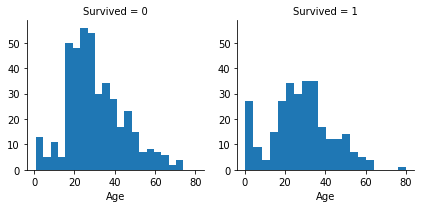

In [7]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

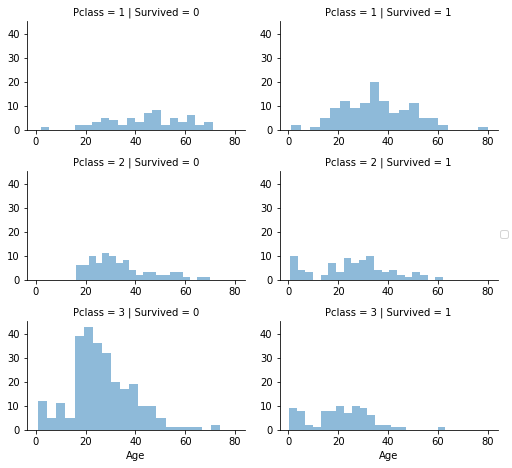

In [8]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

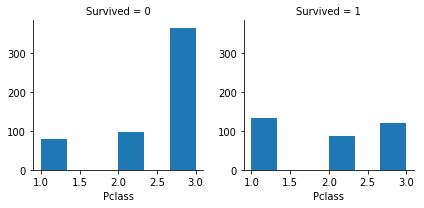

In [9]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Pclass', bins=6)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


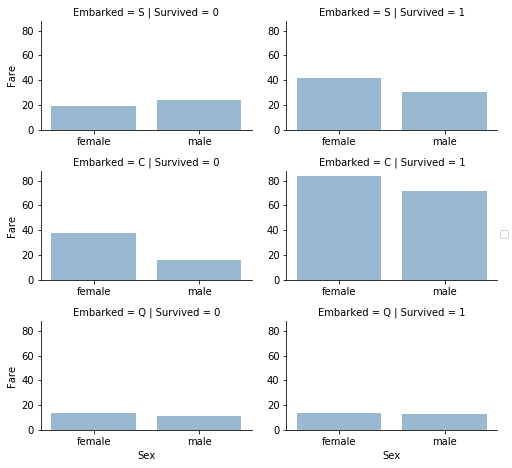

In [10]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()


In [11]:
train_df= train_df.drop(columns=['Cabin', 'Ticket'])
test_df = test_df.drop(columns=['Cabin', 'Ticket'])
combine = [train_df, test_df]
print (train_df.head())

#dealing name data
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

   PassengerId  Survived  Pclass    ...    Parch     Fare  Embarked
0            1         0       3    ...        0   7.2500         S
1            2         1       1    ...        0  71.2833         C
2            3         1       3    ...        0   7.9250         S
3            4         1       1    ...        0  53.1000         S
4            5         0       3    ...        0   8.0500         S

[5 rows x 10 columns]


,Title,Survived
0,Master,0.589744
1,Miss,0.711111
2,Mr,0.157895
3,Mrs,0.793651
4,Rare,0.347826


In [12]:
mask_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(mask_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [13]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((881, 9), (418, 9))

In [14]:
print(dataset['Sex'].describe())
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()


count      418
unique       2
top       male
freq       266
Name: Sex, dtype: object


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


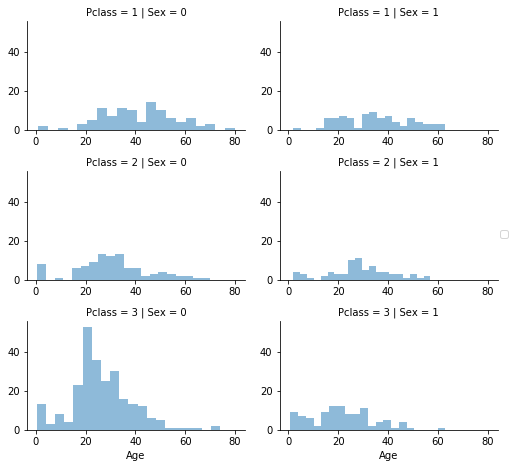

In [15]:
#completing a numerical continous feature for missing values
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()


In [16]:
#empty array to store age values based on pclass*
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()


            

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [17]:
#transform age into age band
train_df['AgeBand'] = pd.cut(train_df['Age'],5)
print (train_df[['AgeBand', 'Survived']].groupby(['AgeBand']).agg({'Survived': np.average}))

               Survived
AgeBand                
(-0.08, 16.0]  0.550000
(16.0, 32.0]   0.340206
(32.0, 48.0]   0.412037
(48.0, 64.0]   0.434783
(64.0, 80.0]   0.090909


In [18]:
#replace age data with age bands
for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age'] = 0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32), 'Age'] = 1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48), 'Age'] = 2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64), 'Age'] = 3
    dataset.loc[(dataset['Age']>64)&(dataset['Age']<=80), 'Age'] = 3
train_df.head()
    

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [19]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [20]:
#create new feature family size
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000


In [21]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [22]:
#drop parch, sibsp, and family size feature in favor of is isalon
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [23]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [24]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.341195


In [25]:
#converting to categorical feature to numeric
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({"S":0, "C":1, "Q":2}).astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


In [26]:
# convert fare data
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [27]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 30.5]",0.456221
3,"(30.5, 512.329]",0.594470


In [28]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)



,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [35]:
#model, predict and solve
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df.drop("PassengerId", axis=1)

#gridsearchcv will be used for models that have higher than %82 accuracy
kfold = StratifiedKFold(n_splits=10)
#first try with logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log



80.700000000000003

In [48]:
# Support Vector Machines with default parameters

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print("accuracy without cross validation is "+str(acc_svc))

print ("svm accuracy averaged over 10 folds cross validation is "+str(cross_val_score(svc,X_train, y= Y_train, scoring='accuracy', cv =kfold, n_jobs=4 ).mean()))

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy without cross validation is 83.54


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:194: FutureWarning: The default 

svm accuracy averaged over 10 folds cross validation is 0.810457099081


In [40]:
#improve SVM model with gridsearch
svc_param_grid = {'kernel':['rbf'], 'gamma':[0.001, 0.01, 0.1, 1], 'C':[1, 10, 50, 100, 200, 300, 1000]}
svm_best_classifier = GridSearchCV(svc, param_grid = svc_param_grid, cv=kfold, scoring='accuracy', n_jobs= 4, verbose=1)
svm_best_classifier.fit(X_train, Y_train)
svm_bestpara = svm_best_classifier.best_estimator_
print (svm_bestpara)
#best score (mean cross-validation of the classifier with best para)
print (svm_best_classifier.best_score_)

#0.824 has been improved from 0.8104

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:    2.4s


SVC(C=200, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.824063564132


[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:    3.5s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
#knn
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print ("knn accuracy without cross validation is "+str(acc_knn))

knn accuracy without cross validation is 82.63


In [50]:
#knn with cross validation 
print ("KNN accuracy averaged over 10 folds cross validation is "+str(cross_val_score(knn,X_train, y= Y_train, scoring='accuracy', cv =kfold, n_jobs=4 ).mean()))


KNN accuracy averaged over 10 folds cross validation is 0.788968335036


In [52]:
#knn improvement 
knn_param_grid = {'n_neighbors':[1,2,3,4,5]}
knn_best_classifier = GridSearchCV(knn, param_grid = knn_param_grid, cv=kfold, scoring='accuracy', n_jobs= 4, verbose=1)
knn_best_classifier.fit(X_train, Y_train)
knn_bestpara = knn_best_classifier.best_estimator_
print (knn_bestpara)
#best score (mean cross-validation of the classifier with best para)
print (knn_best_classifier.best_score_)


Fitting 10 folds for each of 5 candidates, totalling 50 fits
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.805902383655


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [32]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.189999999999998

In [33]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.379999999999995

In [53]:
# Decision Tree cross validation average
print ("Decision tree accuracy averaged over 10 folds cross validation is "+str(cross_val_score(decision_tree,X_train, y= Y_train, scoring='accuracy', cv =kfold, n_jobs=4 ).mean()))

Decision tree accuracy averaged over 10 folds cross validation is 0.794637385087


In [76]:
# Decision Tree improvement (hyperparamer tunning)
## Search grid for optimal parameters
rf_param_grid = { 'criterion': ['gini', 'entropy'], # di buku, katanya kurang lebih sama
                'min_samples_leaf': [1, 10, 20],
                'max_depth': [3, 6, 9, 12],
                'class_weight': [None, 'balanced'],
                'max_features': [1, 3, 5, 8],
                'presort': [True],
                'random_state': [0]}

rf_optimal = GridSearchCV(decision_tree,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
rf_optimal.fit(X_train, Y_train)
print (rf_optimal.best_estimator_)
print (rf_optimal.best_score_)

dt = rf_optimal.best_estimator_
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)
acc_decision_tree = round(dt.score(X_train, Y_train) * 100, 2)
print('best accuracy is '+str(acc_decision_tree))



Fitting 10 folds for each of 192 candidates, totalling 1920 fits
DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=True, random_state=0, splitter='best')
0.820658342792
best accuracy is 83.65


[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed:    1.8s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


86.379999999999995

In [ ]:
# deep neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam

model = Sequential()
model.add(Dense(10, activation="relu", input_shape=(8,)))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100)

          



In [77]:
#now# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest 

86.379999999999995

In [80]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 8],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   38.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8149829738933031

In [85]:

# try Adaboost
DTC = DecisionTreeClassifier()
DTC.fit(X_train,Y_train)
acc_ada = round(DTC.score(X_train, Y_train) * 100, 2)
print ("without grid search the accuracy is "+str(acc_ada))

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

without grid search the accuracy is 86.38
Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    1.8s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:718: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.80022701475595914